In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyswarms as ps

from indicator import Indicator
from preparation import Preparation
from ANN import ANN

In [2]:
# initial value
TRAIN_PATH = 'data/AAPL-2014-2018.csv'
TEST_PATH = 'data/AAPL-30.csv'

N_IN = 14  # number of date for training
N_OUT = 10  # number of date for predict
DIM = N_IN * 6  # dimension for baseline model

PARTICLE = 100  # number of PSO particle
ITERATION = 10  # number of PSO iteration
C1 = 1
C2 = 2
W = 0.01


In [3]:
# setup baseline model
ann = ANN(epochs=10, batch=10, n_in=N_IN, n_out=N_OUT)

In [4]:
# prepare train data
read_data = pd.read_csv(TRAIN_PATH)
preparation = Preparation(df=read_data)
data = preparation.calculate_per_change()
dataset = ann.pre_process_data(data, data.columns)
train_X, train_y, sc = ann.split_data_scale_transform(dataset)
ann.set_train(train_X, train_y)

In [5]:
# training baseline model
history = ann.baseline_train()
annModel = ann.get_baseline_model()

Epoch 1/10
99/99 [==============================] - 0s 3ms/step - loss: 0.0090 - val_loss: 0.0137
Epoch 2/10
99/99 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0136
Epoch 3/10
99/99 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0137

In [6]:
# prepare test data
test_data = pd.read_csv(TEST_PATH)
preparation_test = Preparation(df=test_data)
last_close = preparation_test.get_close()
data_test = preparation_test.calculate_per_change()

test_sample = ann.pre_process_data(data_test, data_test.columns)
test_transform = sc.transform(test_sample)
test_X, test_y = test_transform[:, :-N_OUT], test_transform[:, -N_OUT:]
ann.set_test(test_X[0].reshape(1, DIM), test_y[0])

In [7]:
# predict value from baseline model
predict = annModel.predict(test_X[0].reshape(1, DIM))
weight = annModel.get_weights()

In [8]:
# initialize swarm
options = {'c1': C1, 'c2': C2, 'w': W}
dimensions = annModel.count_params()
max_bound = 0.5 * np.ones(dimensions)
min_bound = - max_bound
bounds = (min_bound, max_bound)

In [9]:
# define objective function for PSO
def objective_function(x):
    n_particles = x.shape[0]
    j = [ann.evaluate_model_pso(x[i]) for i in range(n_particles)]
    return np.array(j)

In [10]:
# call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=PARTICLE, dimensions=dimensions, options=options, bounds=bounds)

In [11]:
# optimize PSO
cost, pos = optimizer.optimize(objective_function, iters=ITERATION, verbose=1)

2020-12-03 21:26:02,686 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1, 'c2': 2, 'w': 0.01}
pyswarms.single.global_best:   0%|          |0/102020-12-03 21:26:05,198 - tensorflow - WARNING - Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0000s vs `on_test_batch_end` time: 0.0010s). Check your callbacks.
2020-12-03 21:26:11,110 - tensorflow - WARNING - Callbacks method `on_test_batch_begin` is slow compared to the batch time (batch time: 0.0000s vs `on_test_batch_begin` time: 0.0010s). Check your callbacks.
2020-12-03 21:26:11,111 - tensorflow - WARNING - Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0000s vs `on_test_batch_end` time: 0.0010s). Check your callbacks.
2020-12-03 21:26:18,336 - tensorflow - WARNING - Callbacks method `on_test_batch_begin` is slow compared to the batch time (batch time: 0.0000s vs `on_test_batch_begin` time: 0.0010s). Check your callbacks.
2020-12-03 

124/124 [==============================] - 0s 1ms/step - loss: 0.0145


In [12]:
# predict value from baseline model with PSO optimize
pso_model = ann.model_pso(pos)
history_pso = pso_model.history
pso_predict = pso_model.predict(test_X[0].reshape(1, DIM))

In [13]:
# reversed value to original value
pso_temps = np.concatenate((test_X[0].reshape(1, DIM), pso_predict), axis=1)
pso_reversed = sc.inverse_transform(pso_temps)
pso_predict_changes = pso_reversed[:, -N_OUT:]

ann_predict_temps = np.concatenate((test_X[0].reshape(1, DIM), predict), axis=1)
ann_predict_reversed = sc.inverse_transform(ann_predict_temps)
ann_predict_changes = ann_predict_reversed[:, -N_OUT:]

In [14]:
# transform percent change to close value
close_change_ann = preparation_test.get_close_all(ann_predict_changes, last_close)
close_change_pso = preparation_test.get_close_all(pso_predict_changes, last_close)

In [15]:
# get close value
test_close_columns = test_data['Close']
close_change_columns_ann = close_change_ann['Close']
close_change_columns_pso = close_change_pso['Close']

In [16]:
# create close price dataframe
close_columns_frame_ann = [test_close_columns[:-N_OUT], close_change_columns_ann]
close_columns_ann = pd.concat(close_columns_frame_ann)
close_columns_ann = close_columns_ann.reset_index()
close_columns_ann.drop('index', axis=1, inplace=True)

close_columns_frame_pso = [test_close_columns[:-N_OUT], close_change_columns_pso]
close_columns_pso = pd.concat(close_columns_frame_pso)
close_columns_pso = close_columns_pso.reset_index()
close_columns_pso.drop('index', axis=1, inplace=True)

In [17]:
# create indicator
indicator_ann_predict = Indicator(close_columns_ann)
indicator_data_ann_predict = indicator_ann_predict.RSI()
indicator_data_ann_predict = indicator_ann_predict.EMA()
indicator_data_ann_predict = indicator_ann_predict.MACD()

indicator_pso_predict = Indicator(close_columns_pso)
indicator_data_pso_predict = indicator_pso_predict.RSI()
indicator_data_pso_predict = indicator_pso_predict.EMA()
indicator_data_pso_predict = indicator_pso_predict.MACD()

indicator_test = Indicator(test_data)
indicator_test_data = indicator_test.RSI()
indicator_test_data = indicator_test.EMA()
indicator_test_data = indicator_test.MACD()

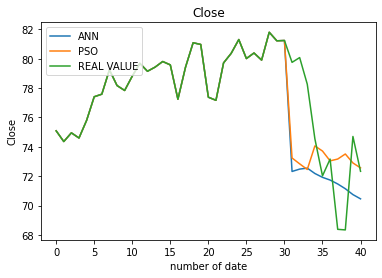

In [18]:
# show close value
plt.plot(indicator_data_ann_predict['Close'], label='ANN')
plt.plot(indicator_data_pso_predict['Close'], label='PSO')
plt.plot(indicator_test_data['Close'], label='REAL VALUE')
plt.title('Close')
plt.ylabel('Close')
plt.xlabel('number of date')
plt.legend(loc='upper left')
plt.show()

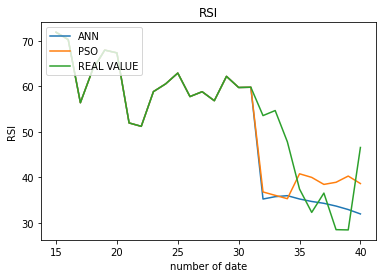

In [19]:
# show RSI 14
plt.plot(indicator_data_ann_predict['rsi'], label='ANN')
plt.plot(indicator_data_pso_predict['rsi'], label='PSO')
plt.plot(indicator_test_data['rsi'], label='REAL VALUE')
plt.title('RSI')
plt.ylabel('RSI')
plt.xlabel('number of date')
plt.legend(loc='upper left')
plt.show()

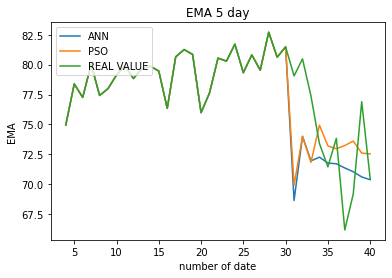

In [20]:
# show EMA 5 day
plt.plot(indicator_data_ann_predict['ema_5_day'], label='ANN')
plt.plot(indicator_data_pso_predict['ema_5_day'], label='PSO')
plt.plot(indicator_test_data['ema_5_day'], label='REAL VALUE')
plt.title('EMA 5 day')
plt.ylabel('EMA')
plt.xlabel('number of date')
plt.legend(loc='upper left')
plt.show()

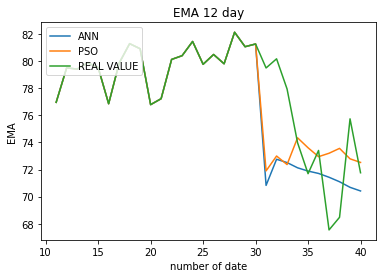

In [21]:
# show EMA 12 day
plt.plot(indicator_data_ann_predict['ema_12_day'], label='ANN')
plt.plot(indicator_data_pso_predict['ema_12_day'], label='PSO')
plt.plot(indicator_test_data['ema_12_day'], label='REAL VALUE')
plt.title('EMA 12 day')
plt.ylabel('EMA')
plt.xlabel('number of date')
plt.legend(loc='upper left')
plt.show()

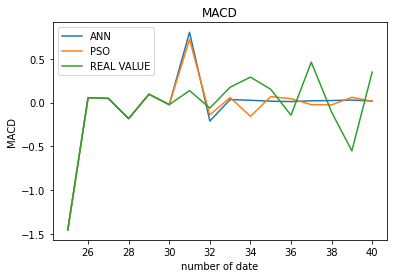

In [22]:
# show MACD
plt.plot(indicator_data_ann_predict['MACD'], label='ANN')
plt.plot(indicator_data_pso_predict['MACD'], label='PSO')
plt.plot(indicator_test_data['MACD'], label='REAL VALUE')
plt.title('MACD')
plt.ylabel('MACD')
plt.xlabel('number of date')
plt.legend(loc='upper left')
plt.show()